**more incidents on long flights? in thunderstorms? what predicts the final finding?**
**airline vs airline?** **do eras of Boeing matter?**


# Project Description
There have been no major deviations from the initial timeline.The project schedule remains the same as the initial plan, with data acquisition, cleaning, and exploratory analysis already completed. The remaining tasks will focus on hypothesis testing, final analysis, and report preparation.

The project will conclude with the final analysis and interpretation of results by April 15, 2025.

In the final analysis, we will have

**Descriptive Statistics**, which answer how the Number of Aircraft Incidents varying by Year and month, how frequently the most common cause of incidents occur, the most common Phase of flight during the incident, the common geographic location of the incident, and what percent of injuries are fatal.

**Correlation Analysis** using ANOVA to explain the correlation between weather conditions and aircraft age to incident occurrence, another ANOVA to determine if the number of incidents is statistically different during different lighting conditions, and Moran's I to determine any correlation between geographic location and if an incident happened. If we decide that assumptions are not accurate we will use other methods like chi-squared tests that can handle different assumptions.

**Regression Models** to predict incident occurrence using weather conditions, altitude, and age of aircraft; to predict severity of aircraft damage and injuries using age of the aircraft and fuel on board, and to understand the findings using natural language processing.

# Data Description
**Data Acquisition**: We gathered data from three datasets from "National Transportation Safety Board" which are "avall.mdb" and "Pre2008.mdb," which has data post-1982, and another dataset is "Pre1982.mdb" which has data before 1982. Extracted all the necessary variables for analysis and hypothesis testing and made into .csv files.

**Data Cleaning**: After extracting the required variables from data files, we handled issues such as missing values using methods like .isnull() and .isna(). We have dealt with the missing values by dropping rows, depending on the proportion of missingness. Checked for and removed duplicate rows in the dataset to ensure no redundancy in the data, which might skew the results if not done. Examined the data to differentiate between Numeric and Categorical variables to ensure correct data types are used for analysis, which is crucial for statistical analysis and machine learning models.
All the Outliers are removed to ensure the statistical values are not affected.

**Exploratory Analysis**: All the necessary Exploratory Analyses are conducted to understand the data correctly. 
A dataset before 1982 has 87,039 entries and 20 columns in total. And the one after 1982 has 91,517 entries and 22 columns.

Both datasets have considerable missing values in key attributes, which might impact the statistical analysis. In the Post 1982 dataset, missing values are significant in Latitude, Fuel_on_board, wx_int_precip, and wind_vel_kts. Likewise, Pre-1982 shows missing values in Altitude of occurrence and Cause, limiting the statistical insights.

An analysis of the Number of Incidents per year shows a notable change in the Number of incidents from years before 1982 and after 1982, showing a significant decrease in incidents year by year.

The top 10 incident causes were plotted, with Personal-issue_Task-performance being the most common cause. The top 10 models of aircraft involved in most incidents were also plotted; it shows that the model PA-28 was the most commonly involved in the incidents before 1982, and the 152 model aircraft was the most frequently engaged after 1982.
Most Incidents occurred during the DayLight conditions both before 1982 and after 1982. 

Next Statistical Analysis and Hypothesis testing will be done, and the results will be presented in the coming weeeks.


# Ethical Data Concerns
No reasonable cause for discouraging viewers to fly has been discovered. Reported causes have been counted, but full pictures of the incidents have not been captured. To more fully describe the incidents and explain level of safety, percent chance of experiencing an incident on any given flight may be required. In addition, several graphs are not properly scaled - some with outliers that may be invalid, but several require more analysis.

# Methods
We read in the data from the Microsoft Access Database using a windows computer with the necessary drivers, organized the data a little bit and then saved the data as csv files so that users who do not run Windows can get the data. We read in the data from the csv to make sure other researchers can replicate our results. We use various functions to observe the data and do some cleaning, but we do not attempt to use imputation. We do not use imputation because doing things like replacing missing values with the mean is not helpful and we did not do any multivariate imputation because there is so much missing that we would be trying to use empty observations to predict other empty observations. We used functions like median() and std(), QQ Plots, Box Plots, Histograms, and Correlation Matrices for basic descriptive statistics.

# Preliminary Results

In [2]:
# Import useful modules
import pyodbc
import pandas as pd
import os
import warnings
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import re

In [88]:
# Transform the Microsoft Access Database to a csv file, ignoring the warnings because they're annoying
with warnings.catch_warnings(action="ignore"):
    
    # Determine the current directory
    current_dir = os.getcwd()
    
    #
    #
    # Connect to the first database
    conn_str = (r'DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};'
                fr'DBQ={current_dir}\{'avall.mdb'};')
    conn = pyodbc.connect(conn_str)

    # Make arrays of the columns we want from the "events" and "aircraft" tables
    events_columns = ['ev_id', 'ev_date', 'ev_time', 'latitude', 'longitude', 'mid_air', 'on_ground_collision', 'light_cond', 'sky_ceil_ht', 'wind_vel_kts', 'gust_kts', 'altimeter', 'wx_int_precip', 'ev_highest_injury']
    aircraft_columns = ['ev_id', 'fuel_on_board', 'acft_model', 'acft_make', 'damage']     
    narratives_columns = ['ev_id', 'narr_cause']   
    findings_columns = ['ev_id', 'finding_description'] 

    # NOTE: dates are formatted month/day/year
    #       time is in UTC zulu format
    #       wind velocity and gust speed are in knots
    #       it doesn't look like wx_int_precip is used
    #       the amount of fuel on board is in gallons

    #  Read in the entire table for tables that have more than one column (reading in only the columns needed didn't work)
    events_df = pd.read_sql("SELECT * FROM events", conn)
    aircraft_df = pd.read_sql("SELECT * FROM aircraft", conn)
    narratives_df = pd.read_sql("SELECT * FROM narratives", conn)
    injury_df = pd.read_sql("SELECT * FROM injury", conn)
    findings_df = pd.read_sql("SELECT * FROM Findings", conn)

    # Keep only the desired columns
    events_df = events_df[events_columns]
    aircraft_df = aircraft_df[aircraft_columns]
    narratives_df = narratives_df[narratives_columns]
    findings_df = findings_df[findings_columns]

    # Make the IDs 'ev_id'
    events_df.set_index('ev_id')
    aircraft_df.set_index('ev_id')
    narratives_df.set_index('ev_id')
    findings_df.set_index('ev_id')

    # Split the finding descriptions into lists, using '/' as the singal to separate the strings
    strings = findings_df.to_numpy()
    strings = strings[:, 1]

    for i in range(len(strings)):
        strings[i] = re.split("/", strings[i])

    # Replace the descriptions with the split strings and then group by the ID
    findings_df['finding_description'] = strings
    found = findings_df.groupby(['ev_id'])

    # Instantiate a list that I will use to replace the finding descriptions
    phrase_list = []

    # loop through each group in found
    for group in found:
        unique_phrases = []

        # Loop through each description in the group and check if the description is in unique_phrases
        for phrases in group[1]['finding_description']:
            for description in phrases:
                if description not in unique_phrases:

                    # Remove any '- C' or '- F' and then append to the unique phrases
                    description = re.sub('- C|F$', '', description)
                    unique_phrases.append(description)

        # Append the unique phrases to the phrase list
        phrase_list.append(unique_phrases)

    # Eliminate duplicate rows of findings_df, based off 'ev_id'
    findings_df = findings_df.drop_duplicates('ev_id')

    # Replace the descriptions with the unique phrases
    findings_df['finding_description'] = phrase_list
    findings_df = findings_df.reset_index()
    findings_df.set_index('ev_id')

    # Convert the injury count column to numeric, replacing None with 0
    injury_df['inj_person_count'] = pd.to_numeric(injury_df['inj_person_count'], errors='coerce').fillna(0)

    # Unstack the injury levels and make sure that the total injury counts are used (not filtered by where they were sitting in the plane)
    injury_df = injury_df.groupby(['ev_id', 'injury_level'])['inj_person_count'].sum().unstack(fill_value=0)
    injury_df = injury_df.reset_index()
    injury_df = injury_df.set_index('ev_id')

    # Join everything
    post_2008_df = events_df.join(aircraft_df, lsuffix='_left', rsuffix='_right')
    post_2008_df = post_2008_df.join(narratives_df)
    post_2008_df = post_2008_df.join(findings_df, lsuffix='_left2', rsuffix='_right2')
    post_2008_df = post_2008_df.join(injury_df)

    # Save as a csv
    post_2008_df.to_csv(fr"{os.getcwd()}\Data_Post_2008.csv", mode = 'x')

    #
    #
    # Connect to the second database
    conn_str = (r'DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};'
                fr'DBQ={current_dir}\{'Pre2008.mdb'};')
    conn = pyodbc.connect(conn_str)
    
    # Make arrays of the columns we want from the "events", "aircraft", "narratives",  "occurrences", and "injury" tables
    events_columns = ['ev_id', 'ev_date', 'ev_time', 'latitude', 'longitude', 'mid_air', 'on_ground_collision', 'light_cond', 'sky_ceil_ht', 'wind_vel_kts', 'gust_kts', 'altimeter', 'wx_int_precip', 'ev_highest_injury']
    aircraft_columns = ['ev_id', 'acft_model', 'acft_make', 'damage']
    narratives_columns = ['ev_id', 'narr_cause']
    codes_columns = ['Table', 'Column', 'code_iaids', 'meaning']

    # NOTE: we'll need to use natural language processing to understand narr_cause
    #       Pre2008 doesn't have 'fuel_on_board'
    
    # Read in the tables
    events_df = pd.read_sql("SELECT * FROM events", conn)
    aircraft_df = pd.read_sql("SELECT * FROM aircraft", conn)
    narratives_df = pd.read_sql("SELECT * FROM narratives", conn)
    occurrences_df = pd.read_sql("SELECT * FROM Occurrences", conn)
    injury_df = pd.read_sql("SELECT * FROM injury", conn)
    codes_1982_to_2008 = pd.read_sql("SELECT * FROM eADMSPUB_DataDictionary", conn)

    # Keep only the desired columns
    events_df = events_df[events_columns]
    aircraft_df = aircraft_df[aircraft_columns]
    narratives_df = narratives_df[narratives_columns]
    codes_1982_to_2008 = codes_1982_to_2008[codes_columns]

    # Filter the codes to just be the 'Occurrence_code' and 'Phase_of_Flight' codes and meanings from the 'Occurrences' table
    codes_1982_to_2008 = codes_1982_to_2008[(codes_1982_to_2008['Table'] == 'Occurrences') & (codes_1982_to_2008['Column'] == 'Occurrence_code') | (codes_1982_to_2008['Column'] == 'Phase_of_Flight')]
    codes_1982_to_2008 = codes_1982_to_2008.drop('Table', axis = 1)
    
    # Change the indices to 'ev_id'
    events_df = events_df.set_index('ev_id')
    aircraft_df = aircraft_df.set_index('ev_id')
    narratives_df = narratives_df.set_index('ev_id')

    # Turn the phase(s) of flight, occurrence code, and altitude into lists with every phase, code, and altitude for each incident
    occurrences_df = occurrences_df.groupby(['ev_id']).agg({'Occurrence_Code': list, 'Phase_of_Flight': list, 'Altitude': list}).reset_index()
    occurrences_df = occurrences_df.set_index('ev_id')

    # Convert the injury count column to numeric, replacing None with 0
    injury_df['inj_person_count'] = pd.to_numeric(injury_df['inj_person_count'], errors='coerce').fillna(0)

    # Unstack the injury levels and make sure that the total injury counts are used (not filtered by where they were sitting in the plane)
    injury_df = injury_df.groupby(['ev_id', 'injury_level'])['inj_person_count'].sum().unstack(fill_value=0)
    injury_df = injury_df.reset_index()
    injury_df = injury_df.set_index('ev_id')

    # Join everything except the codes
    df_1982_to_2008 = occurrences_df.join(events_df)
    df_1982_to_2008 = df_1982_to_2008.join(aircraft_df)
    df_1982_to_2008 = df_1982_to_2008.join(narratives_df)
    df_1982_to_2008 = df_1982_to_2008.join(injury_df)

    # Save to a csv
    df_1982_to_2008.to_csv(fr"{os.getcwd()}\Data_1982_to_2008.csv", mode = 'x')
    codes_1982_to_2008.to_csv(fr"{os.getcwd()}\Codes_for_1982_to_2008.csv", mode = 'x')

    # Shuold we drop any event where injury level is 'TOTL'? Because IDK what it means

    #
    #
    # Connect to the last database
    conn_str = (r'DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};'
                fr'DBQ={current_dir}\{'PRE1982.mdb'};')
    conn = pyodbc.connect(conn_str)

    # Make arrays of the columns we want from the 'tblFirstHalf', 'tblSecondHalf', and 'ct_Pre1982' tables
    tblFirstHalf_columns = ["RecNum", 'DATE_OCCURRENCE', 'TIME_OCCUR', 'LOCATION','LIGHT_COND', 'ALT_OF_OCC', 'ACFT_MODEL', 'ACFT_MAKE', 'ACFT_ADAMG', 'ACCIDENT_TYPE1', 'ACCIDENT_TYPE2',
                            'GRAND_TOTAL_FATAL', 'GRAND_TOTAL_SERIOUS', 'GRAND_TOTAL_MINOR', 'GRAND_TOTAL_NONE']
    tblSecondHalf_columns = ["RecNum", 'CEILING', 'WIND_VELOCITY', 'PRECIPITATION', 'CAUSE'] 
    ct_Pre1982_names = ['ACCIDENT_TYPE', 'CAUSE_FACTOR', 'OPERATION_PHASE', 'PRECIPITATION', 'ACFT_ADAMG', 'LIGHT_COND', 'LOCAT_STATE_TERR']
    tblOcurrances_columns = ["RecNum", 'Altitude', 'PhaseOfFlight']

    # NOTE: the closest I found to 'wx_int_precip' was 'Precipitation' (Precipitation from the ct_Pre1982 table has the codes),
    #       the closest I found to 'latitude' and 'longitude' is 'location' (locat_state_terr has codes), 
    #       the closest I found to 'ev_highest_injury' and 'inj_person_count' were actually four different columns: 'grand_total_fatal', 'grand_total_serious', 'grand_total_minor', 'grand_total_none' 
    #       the closest I found to 'finding_description' was three different columns: 'Accident_Type1' & 'Accident_Type2' (Accident_Type has codes) and 'Cause' (cause_factor has codes)
    #       the closest I found to 'on_ground_collision' is 'PhaseOfFlight' (operation_phase has the codes)
    #       didn't find anything that matched 'fuel_on_board', 'altimeter', or 'gust_kts'
    #       Items with the same RecNum or ev_id are from the same event
    #       I couldn't join the tables so that the RecNum or ev_id columns merged, so there's two columns for each - with suffixes '_left' and '_right'. YOU SHOULD DROP THESE

    # Read in each table
    tblFirstHalf = pd.read_sql("SELECT * FROM tblFirstHalf", conn)
    tblSeconfHalf = pd.read_sql("SELECT * FROM tblSecondHalf", conn)
    ct_Pre1982 = pd.read_sql("SELECT * FROM ct_Pre1982", conn)
    tblOcurrances = pd.read_sql("SELECT * FROM tblOccurrences", conn)

    # set the index to be the 'Name' column, that way my code works
    ct_Pre1982.set_index('Name', inplace = True)

    # Keep only the desired columns
    tblFirstHalf = tblFirstHalf[tblFirstHalf_columns]
    tblSeconfHalf = tblSeconfHalf[tblSecondHalf_columns]
    ct_Pre1982 = ct_Pre1982.loc[ct_Pre1982_names]
    tblOcurrances = tblOcurrances[tblOcurrances_columns]

    # Join the dataframes
    main_df1 = tblFirstHalf.join(tblSeconfHalf, lsuffix='_left', rsuffix='_right')
    main_df2 = main_df1.join(tblOcurrances, lsuffix='_left', rsuffix='_right')

    # save the file to a csv
    ct_Pre1982.to_csv(fr"{os.getcwd()}\Codes_For_Data_Before_1982.csv", mode = 'x')
    main_df2.to_csv(fr"{os.getcwd()}\Data_Before_1982.csv", mode = 'x')


#### claude ai conversations

**Question:** <br>I run comment#Import useful modules
import pyodbc
import pandas as pd
import os
comment#Determine the paths to the files
current_dir = os.getcwd()
path_older_data = fr"{current_dir}\Pre2008.mdb;"
comment#Read in desired data from the file with data 2008 and more recent
comment#Connect to the database - NOTE: You must NOT have the database open
conn_str = (r'DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};'
            fr'{current_dir}\avall.mdb;')
conn = pyodbc.connect(conn_str)
comment#Read in the entire tables for tables that have more than one column (reading in only the columns needed didn't work)
events_df = pd.read_sql("SELECT * FROM events", conn)
aircraft_df = pd.read_sql("SELECT * FROM aircraft", conn)
comment#Read in the columns from the tables that only have one or two columns
inj_person_count = pd.read_sql("SELECT inj_person_count FROM injury", conn)
altitude = pd.read_sql("SELECT Altitude FROM Occurrences", conn)
finding_description = pd.read_sql("SELECT finding_description FROM Findings", conn)
comment#Make arrays of the columns we want from the "events" and "aircraft" tables
events_columns = ['ev_date', 'ev_time', 'latitude', 'longitude', 'mid_air', 'on_ground_collision', 'light_cond', 'sky_ceil_ht', 'wind_vel_kts', 'gust_kts', 'altimeter', 'wx_int_precip', 'ev_highest_injury']
aircraft_columns = ['fuel_on_board', 'acft_model', 'acft_make', 'damage']
comment#Keep only the desired columns
events_df = events_df[events_columns]
aircraft_df = aircraft_df[aircraft_columns]
comment#Concatonate the dataframes
df_2008 = events_df.join(aircraft_df)
comment#add the columns that were read in on their own
df_2008['inj_person_count'] = inj_person_count
df_2008['altitude'] = altitude
df_2008['finding_description'] = finding_description
comment#Print the main dataframe
print(df_2008.head())
and get Error: ('01S00', '[01S00] [Microsoft][ODBC Driver Manager] Invalid connection string attribute (0) (SQLDriverConnect)')<br>
**Answer:** <br>You're missing the 'DBQ=' parameter before the file path. Try this: pythonCopyconn_str = (r'DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};'fr'DBQ={current_dir}\avall.mdb;')<br>
**Action Taken:** <br>I replaced conn_str = (r'DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};'fr'{current_dir}\avall.mdb;') 
with (r'DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};'fr'DBQ={current_dir}\avall.mdb;')<br><br><br>

**Question:** <br>Why is this code not working?
comment#Import useful modules
import pyodbc
import pandas as pd
comment#Connect to the database - NOTE: You must NOT have the database open
conn_str = (r'DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};'
            r'DBQ=C:\Users\erken\Desktop\School Stuff\Intro to Data Science\Intro_To_Data_Science\avall.mdb;')
conn = pyodbc.connect(conn_str)
comment#Read in desired data from the file with data 2008 and more recent
comment#Read in the entire tables for tables that have more than one column (reading in only the columns needed didn't work)
events_df = pd.read_sql("SELECT * FROM events", conn)
aircraft_df = pd.read_sql("SELECT * FROM aircraft", conn)
comment#Read in the columns from the tables that only have one or two columns
inj_person_count = pd.read_sql("SELECT inj_person_count FROM injury", conn)
altitude = pd.read_sql("SELECT Altitude FROM Occurrences", conn)
finding_description = pd.read_sql("SELECT finding_description FROM Findings", conn)
comment#Make arrays of the columns we want from the "events" and "aircraft" tables
events_columns = ['ev_date', 'ev_time', 'latitude', 'longitude', 'mid_air', 'on_ground_collision', 'light_cond', 'sky_ceil_ht', 'wind_vel_kts', 'gust_kts', 'altimeter', 'wx_int_precip', 'ev_highest_injury']
aircraft_columns = ['fuel_on_board', 'acft_model', 'acft_make', 'damage']
print(events_df.columns)
comment#If a column of events_df is not in events_columns, then drop the column from events_df
for column in events_df.columns:
    if not column in events_columns:
        events_df.drop(column)<br>
**Answer:** <br>The main issue is that your drop columns code isn't working because .drop() doesn't modify the DataFrame in place by default. You need to either:
Use inplace=True:
pythonCopyfor column in events_df.columns:
    if column not in events_columns:
        events_df.drop(column, inplace=True)
Or assign the result back:
pythonCopyfor column in events_df.columns:
    if column not in events_columns:
        events_df = events_df.drop(column, axis=1)
A better approach would be:
pythonCopyevents_df = events_df[events_columns]
aircraft_df = aircraft_df[aircraft_columns]<br>
**Action Taken:** <br>replaced 
comment#If a column of events_df is not in events_columns, then drop the column from events_df
for column in events_df.columns:
    if not column in events_columns:
        events_df.drop(column)
with
comment#Keep only the desired columns
    events_df = events_df[events_columns]
    aircraft_df = aircraft_df[aircraft_columns]<br><br><br>

**Question:** <br>df = pd.read_sql('select column1, column2  from table_name', conn) 
is that the right syntax for selecting different entries from a table?<br>
**Answer:** <br>Yes, your syntax for reading from a SQL table using pandas is correct:
pythonCopydf = pd.read_sql('select column1, column2 from table_name', conn)
This code will execute the SQL query and store the results in a pandas DataFrame. The conn object should be your database connection.<br>
**Action Taken** <br>ask the following question: <br><br><br>

**Question:** <br>I run # Import useful modules
import pyodbc
import pandas as pd
comment#Connect to the database - NOTE: You must NOT have the database open
conn_str = (r'DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};'
            r'DBQ=C:\Users\erken\Desktop\School Stuff\Intro to Data Science\Intro_To_Data_Science\avall.mdb;')
conn = pyodbc.connect(conn_str)
comment#Read in desired data from the file with data 2008 and more recent
comment#Desired entries are ev_date, ev_time, latitude, longitude, mid_air, on_ground_collision, light_cond, sky_ceil_ht, wind_vel_kts, gust_kt, 
comment#altimeter, wx_int_precip, fuel_on_board, acft_model, acft_make, damage, Altitude, inj_person_count, and finding_description
df_2008 = pd.read_sql('SELECT ev_date, ev_time, latitude, longitude, mid_air, on_ground_collision, light_cond, sky_ceil_ht, '
                      'wind_vel_kts, gust_kt, altimeter, wx_int_precip, ev_highest_injury FROM events', conn)
I get the error Error: ('07002', '[07002] [Microsoft][ODBC Microsoft Access Driver] Too few parameters. Expected 1. (-3010) (SQLExecDirectW)') <br>
**Answer:** <br>The error message indicates you're missing a parameter that the query expects. This typically happens when your SQL contains a parameter placeholder (often marked with ? or @parameter) but you haven't provided the corresponding value.
Looking at your query, I don't see any explicit parameter placeholders, but Access might be interpreting something in your query as a parameter. Some possible fixes:
Check for special characters in column names that might need to be escaped (try enclosing column names in square brackets):
pythonCopydf_2008 = pd.read_sql('SELECT ev_date, ev_time, latitude, longitude, mid_air, on_ground_collision, [light_cond], [sky_ceil_ht], '
                     '[wind_vel_kts], [gust_kt], altimeter, wx_int_precip, ev_highest_injury FROM events', conn)
Try using a parameterized query explicitly if you need one:
pythonCopydf_2008 = pd.read_sql('SELECT * FROM events WHERE some_column = ?', conn, params=('parameter_value',))
Check if any column names contain reserved words that need bracketing.<br>
**Action Taken:** <br>ask the following question: <br><br><br>

**Question:** <br>Here are the SQL tables 
and here is what the file shows (I inserted images of the database schema and the actual program) <br>
**Answer:** <br>Based on the images, I can see that you need to use the dt_events table since it's selected in image 2, and I can see all the available fields in image 1.
Try this corrected query with square brackets around column names:
pythonCopydf_2008 = pd.read_sql('SELECT [ev_date], [ev_time], [latitude], [longitude], [mid_air], [on_ground_collision], [light_cond], [sky_ceil_ht], [wind_vel_kts], [gust_kts], [altimeter], [wx_int_precip], [ev_highest_injury] FROM [dt_events]', conn)
Key corrections:
Added square brackets around all column names and table name
Notice I changed gust_kt to gust_kts based on image 1
If issues persist, try using a cursor approach instead:
pythonCopycursor = conn.cursor()
cursor.execute('SELECT [ev_date], [ev_time], [latitude], [longitude], [mid_air], [on_ground_collision], [light_cond], [sky_ceil_ht], [wind_vel_kts], [gust_kts], [altimeter], [wx_int_precip], [ev_highest_injury] FROM [dt_events]')
df_2008 = pd.DataFrame.from_records(cursor.fetchall(), columns=[col[0] for col in cursor.description]) <br>
**Action Taken:** <br>ask the following question: <br><br><br>

**Question:** <br>I tried both and still get Error: ('07002', '[07002] [Microsoft][ODBC Microsoft Access Driver] Too few parameters. Expected 13. (-3010) (SQLExecDirectW)') <br>
**Answer:** <br>The "Too few parameters. Expected 13" error suggests MS Access is still interpreting column names as parameters. Let's try more aggressive approaches:
Try with double brackets:
pythonCopydf_2008 = pd.read_sql("SELECT [[ev_date]], [[ev_time]], [[latitude]], [[longitude]], [[mid_air]], [[on_ground_collision]], [[light_cond]], [[sky_ceil_ht]], [[wind_vel_kts]], [[gust_kts]], [[altimeter]], [[wx_int_precip]], [[ev_highest_injury]] FROM [[dt_events]]", conn)
Try a simpler query first to verify basic connectivity:
pythonCopytest_df = pd.read_sql("SELECT [ev_id] FROM [dt_events]", conn)
Or try retrieving all columns, which sometimes avoids parameter issues:
pythonCopydf_2008 = pd.read_sql("SELECT * FROM [dt_events]", conn)<br>
**Action Taken:**<br> Try those too, settle on getting all the columns and then filtering afterwards<br><br><br>

**Question:** <br>Here is a sample from a database table, I want to combine 'Phase_of_Flight' data from each 'ev_id' into one entry (the entry would be a list of each phase of flight that correspond to the ev_id) (I inserted an image of the Occurrences table form Pre2008_mdb)<br>
**Answer:** <br> result_df = df.groupby(['ev_id', 'Aircraft_Key']).agg({'Phase_of_Flight': lambda x: list(x)}).reset_index()
print("Method 1 Result:")
print(result_df)<br>
**Action Taken:** I replaced the code that created new columns to see if it worked, then adjusted it a little to fit my code better

In [8]:
aircraft_files = ['Data_Starting_1982.csv', 'Data_Before_1982.csv', 'Codes_For_Data_Before_1982.csv']
# Reading CSV files
data_start_1982 = pd.read_csv(aircraft_files[0])
data_before_1982 = pd.read_csv(aircraft_files[1])
data_codes_before_1982 = pd.read_csv(aircraft_files[2])

# Checking the first few rows of each dataset
print(data_start_1982.head(5))
print(data_before_1982.head(5))
print(data_codes_before_1982.head(5))

   Unnamed: 0      ev_id_left     ev_date  ev_time latitude longitude mid_air  \
0           0  20001204X00000  1999-01-10   1730.0  594421N  1615323W     NaN   
1           1  20001204X00001  1999-01-19    726.0  064541N  0148938W     NaN   
2           2  20001204X00002  1999-01-05   1825.0  061938N  1495927W     NaN   
3           3  20001204X00003  1999-01-10   1751.0  604837N  1615058W     NaN   
4           4  20001204X00004  1999-01-12   1450.0  613151N  0165360W     NaN   

  on_ground_collision light_cond  sky_ceil_ht  ...  wx_int_precip  \
0                 NaN       DAYL       1000.0  ...            NaN   
1                 NaN       NDRK          0.0  ...            NaN   
2                 NaN       DAYL       2500.0  ...            NaN   
3                 NaN       DAYL        600.0  ...            NaN   
4                 NaN       DAWN        700.0  ...            NaN   

   ev_highest_injury     ev_id_right            acft_model  \
0               MINR  20001204X00000

In [9]:
# Inspecting the data info and summary statistics
print(data_start_1982.info())
print(data_before_1982.info())
print(data_codes_before_1982.info())

print(data_start_1982.describe())
print(data_before_1982.describe())
print(data_codes_before_1982.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91517 entries, 0 to 91516
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           91517 non-null  int64  
 1   ev_id_left           91517 non-null  object 
 2   ev_date              91517 non-null  object 
 3   ev_time              90828 non-null  float64
 4   latitude             76861 non-null  object 
 5   longitude            76860 non-null  object 
 6   mid_air              1711 non-null   object 
 7   on_ground_collision  1711 non-null   object 
 8   light_cond           85218 non-null  object 
 9   sky_ceil_ht          91129 non-null  float64
 10  wind_vel_kts         66713 non-null  float64
 11  gust_kts             91230 non-null  float64
 12  altimeter            91129 non-null  float64
 13  wx_int_precip        0 non-null      float64
 14  ev_highest_injury    89828 non-null  object 
 15  ev_id_right          91517 non-null 

In [ ]:
# Checking missing values
print("\n Missing Values in Data_Starting_1982")
print(data_start_1982.isnull().sum())

print("\n Missing Values in Data_Before_1982")
print(data_before_1982.isnull().sum())

print("\nMissing values in Codes_For_Data_Before_1982.csv:")
print(data_codes_before_1982.isnull().sum())


 Missing Values in Data_Starting_1982
Unnamed: 0                 0
ev_id_left                 0
ev_date                    0
ev_time                  689
latitude               14656
longitude              14657
mid_air                89806
on_ground_collision    89806
light_cond              6299
sky_ceil_ht              388
wind_vel_kts           24804
gust_kts                 287
altimeter                388
wx_int_precip          91517
ev_highest_injury       1689
ev_id_right                0
acft_model                88
acft_make                 61
damage                  3581
inj_person_count       32826
altitude               28515
finding_description    62988
fuel_on_board          82994
dtype: int64

 Missing Values in Data_Before_1982
Unnamed: 0                 0
RecNum_left                0
DATE_OCCURRENCE            1
TIME_OCCUR                13
LOCATION                   1
LIGHT_COND                34
ALT_OF_OCC             61340
ACFT_MODEL                71
ACFT_MAKE   

In [ ]:
# Remove useless columns
columns_to_remove = ['Unnamed: 0', 'RecNum_right','RecNum_left']
data_start_1982 = data_start_1982.drop(columns=columns_to_remove)
data_before_1982 = data_before_1982.drop(columns=columns_to_remove)

In [5]:
#  Check for duplicates and remove them
duplicates_start_1982 = data_start_1982.duplicated().sum()  
duplicates_before_1982 = data_before_1982.duplicated().sum()
duplicates_codes = data_codes_before_1982.duplicated().sum()

# Print the number of duplicate rows before removal
print(f"\nNumber of duplicates before removal (1982 onwards): {duplicates_start_1982}")
print(f"Number of duplicates before removal (Before 1982): {duplicates_before_1982}")
print(f"Number of duplicates before removal (Codes Before 1982): {duplicates_codes}")

# Remove duplicates
data_start_1982_clean = data_start_1982.drop_duplicates()
data_before_1982_clean = data_before_1982.drop_duplicates()
data_codes_before_1982_clean = data_codes_before_1982.drop_duplicates()

# After removing duplicates, check how many duplicates remain
duplicates_start_1982_after = data_start_1982_clean.duplicated().sum()
duplicates_before_1982_after = data_before_1982_clean.duplicated().sum()
duplicates_codes_after = data_codes_before_1982_clean.duplicated().sum()

# Printing the number of duplicates remaining after removal
print(f"Number of duplicates after removal (1982 onwards): {duplicates_start_1982_after}")
print(f"Number of duplicates after removal (Before 1982): {duplicates_before_1982_after}")
print(f"Number of duplicates after removal (Codes Before 1982): {duplicates_codes_after}")


Number of duplicates before removal (1982 onwards): 0
Number of duplicates before removal (Before 1982): 0
Number of duplicates before removal (Codes Before 1982): 0
Number of duplicates after removal (1982 onwards): 0
Number of duplicates after removal (Before 1982): 0
Number of duplicates after removal (Codes Before 1982): 0


In [6]:
# Categorical Columns for both data sets 
categorical_columns_start_1982 = data_start_1982.select_dtypes(include=['object', 'category']).columns
categorical_columns_before_1982 = data_before_1982.select_dtypes(include=['object', 'category']).columns

# Numerical Columns for both data sets
numerical_columns_start_1982 = data_start_1982.select_dtypes(include=['int64', 'float64']).columns
numerical_columns_before_1982 = data_before_1982.select_dtypes(include=['int64', 'float64']).columns

# Print the categorized columns for each dataset
print("\nCategorical columns (1982 onwards):", categorical_columns_start_1982)
print("\nCategorical columns (Before 1982):", categorical_columns_before_1982)

print("\nNumerical columns (1982 onwards):", numerical_columns_start_1982)
print("\nNumerical columns (Before 1982):", numerical_columns_before_1982)


Categorical columns (1982 onwards): Index(['ev_id_left', 'ev_date', 'latitude', 'longitude', 'mid_air',
       'on_ground_collision', 'light_cond', 'ev_highest_injury', 'ev_id_right',
       'acft_model', 'acft_make', 'damage', 'finding_description'],
      dtype='object')

Categorical columns (Before 1982): Index(['DATE_OCCURRENCE', 'TIME_OCCUR', 'LOCATION', 'LIGHT_COND', 'ALT_OF_OCC',
       'ACFT_MODEL', 'ACFT_MAKE', 'ACFT_ADAMG', 'ACCIDENT_TYPE1',
       'ACCIDENT_TYPE2', 'CEILING', 'WIND_VELOCITY', 'PRECIPITATION', 'CAUSE',
       'PhaseOfFlight'],
      dtype='object')

Numerical columns (1982 onwards): Index(['Unnamed: 0', 'ev_time', 'sky_ceil_ht', 'wind_vel_kts', 'gust_kts',
       'altimeter', 'wx_int_precip', 'inj_person_count', 'altitude',
       'fuel_on_board'],
      dtype='object')

Numerical columns (Before 1982): Index(['Unnamed: 0', 'RecNum_left', 'GRAND_TOTAL_FATAL', 'GRAND_TOTAL_SERIOUS',
       'GRAND_TOTAL_MINOR', 'GRAND_TOTAL_NONE', 'RecNum_right', 'RecNum',
   

In [13]:
# Identify numerical and categorical columns
data_start_numerical_columns = data_start_1982_clean.select_dtypes(include=['float64', 'int64']).columns
data_start_categorical_columns = data_start_1982_clean.select_dtypes(include=['object']).columns

data_before_numerical_columns = data_before_1982_clean.select_dtypes(include=['float64', 'int64']).columns
data_before_categorical_columns = data_before_1982_clean.select_dtypes(include=['object']).columns

# Calculate mean and median for numerical columns
print("\nMean and Median for data_start_1982_clean:")
print("Mean:\n", data_start_1982_clean[data_start_numerical_columns].mean())
print("Median:\n", data_start_1982_clean[data_start_numerical_columns].median())

print("\nMean and Median for data_before_1982_clean:")
print("Mean:\n", data_before_1982_clean[data_before_numerical_columns].mean())
print("Median:\n", data_before_1982_clean[data_before_numerical_columns].median())



Mean and Median for data_start_1982_clean:
Mean:
 ev_time             1525.395539
sky_ceil_ht         1979.521865
wind_vel_kts           8.565272
gust_kts               2.514085
altimeter             23.816850
wx_int_precip               NaN
inj_person_count       2.653115
altitude               0.903178
fuel_on_board        274.843781
dtype: float64
Median:
 ev_time             1730.000000
sky_ceil_ht            0.000000
wind_vel_kts           8.000000
gust_kts               0.000000
altimeter             29.870001
wx_int_precip               NaN
inj_person_count       1.000000
altitude               0.000000
fuel_on_board         38.000000
dtype: float64

Mean and Median for data_before_1982_clean:
Mean:
 GRAND_TOTAL_FATAL        0.054701
GRAND_TOTAL_SERIOUS      0.012569
GRAND_TOTAL_MINOR        0.013787
GRAND_TOTAL_NONE         0.172766
Altitude               459.918105
dtype: float64
Median:
 GRAND_TOTAL_FATAL      0.0
GRAND_TOTAL_SERIOUS    0.0
GRAND_TOTAL_MINOR      0.0
GRAND_T

In [15]:
# Calculate mode for categorical columns
print("\nMode for data_start_1982_clean:")
print(data_start_1982_clean[data_start_categorical_columns].mode().iloc[0])

print("\nMode for data_before_1982_clean:")
print(data_before_1982_clean[data_before_categorical_columns].mode().iloc[0])




Mode for data_start_1982_clean:
ev_id_left                                                20001204X00000
ev_date                                                       1983-06-05
latitude                                                         332739N
longitude                                                       0112457W
mid_air                                                                N
on_ground_collision                                                    Y
light_cond                                                          DAYL
ev_highest_injury                                                   NONE
ev_id_right                                               20001212X19172
acft_model                                          152                 
acft_make                                 CESSNA                        
damage                                                              SUBS
finding_description    Personnel issues-Task performance-Use of equip...
Name: 0, dtype: ob

In [17]:
#Dispersion
# Calculate standard deviation for numerical columns
print("\nStandard Deviation for data_start_1982_clean:")
print(data_start_1982_clean[data_start_numerical_columns].std())

print("\nStandard Deviation for data_before_1982_clean:")
print(data_before_1982_clean[data_before_numerical_columns].std())


Standard Deviation for data_start_1982_clean:
ev_time              693.563613
sky_ceil_ht         5384.591610
wind_vel_kts           5.346715
gust_kts               8.612818
altimeter             87.318444
wx_int_precip               NaN
inj_person_count      16.370997
altitude              70.105335
fuel_on_board       8423.004373
dtype: float64

Standard Deviation for data_before_1982_clean:
GRAND_TOTAL_FATAL         3.116679
GRAND_TOTAL_SERIOUS       0.452387
GRAND_TOTAL_MINOR         0.368946
GRAND_TOTAL_NONE          3.839146
Altitude               2359.667108
dtype: float64


In [19]:
# Calculate variance for numerical columns
#print(data_start_numerical_columns)
print("\nVariance for data_start_1982_clean:")
print(data_start_1982_clean[data_start_numerical_columns].var())

#print(data_before_numerical_columns)
print("\nVariance for data_before_1982_clean:")
print(data_before_1982_clean[data_before_numerical_columns].var())


Variance for data_start_1982_clean:
ev_time             4.810305e+05
sky_ceil_ht         2.899383e+07
wind_vel_kts        2.858736e+01
gust_kts            7.418064e+01
altimeter           7.624511e+03
wx_int_precip                NaN
inj_person_count    2.680096e+02
altitude            4.914758e+03
fuel_on_board       7.094700e+07
dtype: float64

Variance for data_before_1982_clean:
GRAND_TOTAL_FATAL      9.713688e+00
GRAND_TOTAL_SERIOUS    2.046538e-01
GRAND_TOTAL_MINOR      1.361213e-01
GRAND_TOTAL_NONE       1.473904e+01
Altitude               5.568029e+06
dtype: float64


In [21]:
# Function to calculate the 95% confidence interval for each numerical column
def confidence_interval(data, column):
    mean = data[column].mean()
    std = data[column].std()
    n = data[column].count()
    conf_int = stats.t.interval(0.95, n-1, loc=mean, scale=std/np.sqrt(n))
    return conf_int

print("\n95% Confidence Interval for data_start_1982_clean:")
for col in data_start_numerical_columns:
    print(f"{col}: {confidence_interval(data_start_1982_clean, col)}")

print("\n95% Confidence Interval for data_before_1982_clean:")
for col in data_before_numerical_columns:
    print(f"{col}: {confidence_interval(data_before_1982_clean, col)}")


95% Confidence Interval for data_start_1982_clean:
ev_time: (1520.8849804949805, 1529.9060971462754)
sky_ceil_ht: (1944.5613089020094, 2014.4824203170097)
wind_vel_kts: (8.524699075453297, 8.60584519627785)
gust_kts: (2.458195769627479, 2.5699747883030266)
altimeter: (23.249916918203606, 24.383782412419198)
wx_int_precip: (nan, nan)
inj_person_count: (2.5206671559518403, 2.785563782352159)
altitude: (0.35574548418162766, 1.4506098696166645)
fuel_on_board: (95.99723409191157, 453.6903277994412)

95% Confidence Interval for data_before_1982_clean:
GRAND_TOTAL_FATAL: (0.03399496757521988, 0.0754067811063753)
GRAND_TOTAL_SERIOUS: (0.009563899161292, 0.01557483494029698)
GRAND_TOTAL_MINOR: (0.011336116081964914, 0.016238363736962667)
GRAND_TOTAL_NONE: (0.1472599329209753, 0.19827127794336977)
Altitude: (440.6368915737237, 479.19931816957194)


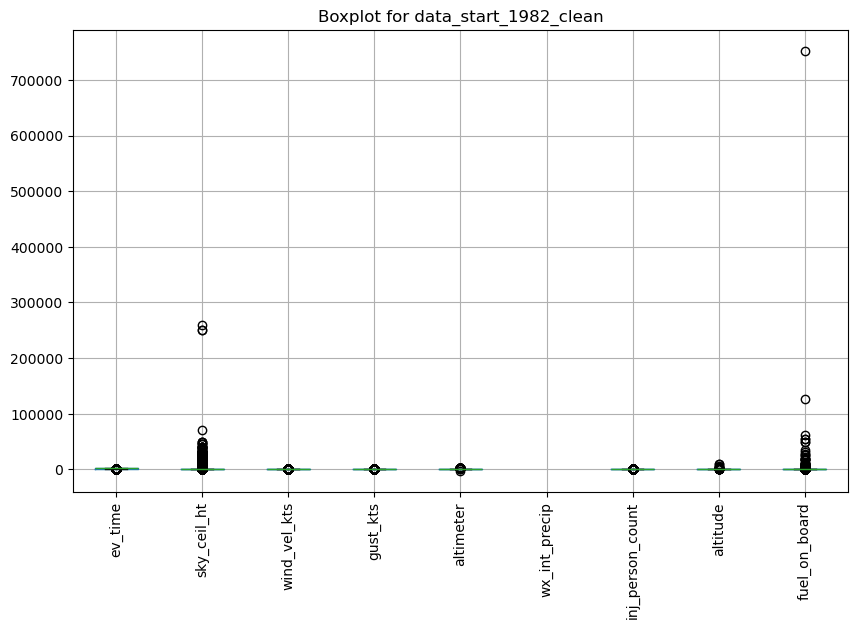

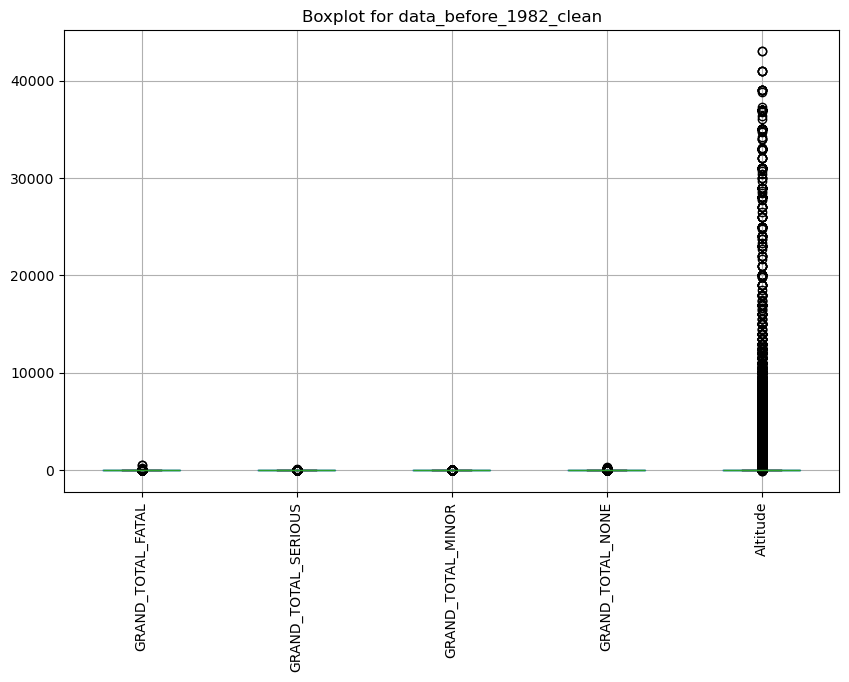

In [ ]:
# Boxplot for numerical columns in data_start_1982_clean
plt.figure(figsize=(10, 6))
data_start_1982_clean[data_start_numerical_columns].boxplot()
plt.title("Boxplot for data_start_1982_clean")
plt.xticks(rotation=90)
plt.show()


# Boxplot for numerical columns in data_before_1982_clean
plt.figure(figsize=(10, 6))
data_before_1982_clean[data_before_numerical_columns].boxplot()
plt.title("Boxplot for data_before_1982_clean")
plt.xticks(rotation=90)
plt.show()

In [25]:
# Identify outliers using boxplots
def identify_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers

for col in data_start_numerical_columns:
    outliers = identify_outliers(data_start_1982_clean, col)
    print(f"\nOutliers in {col} for data_start_1982_clean: {outliers.shape[0]} rows")

for col in data_before_numerical_columns:
    outliers = identify_outliers(data_before_1982_clean, col)
    print(f"\nOutliers in {col} for data_before_1982_clean: {outliers.shape[0]} rows")


Outliers in ev_time for data_start_1982_clean: 11224 rows

Outliers in sky_ceil_ht for data_start_1982_clean: 21134 rows

Outliers in wind_vel_kts for data_start_1982_clean: 3324 rows

Outliers in gust_kts for data_start_1982_clean: 11111 rows

Outliers in altimeter for data_start_1982_clean: 79 rows

Outliers in wx_int_precip for data_start_1982_clean: 0 rows

Outliers in inj_person_count for data_start_1982_clean: 4282 rows

Outliers in altitude for data_start_1982_clean: 23 rows

Outliers in fuel_on_board for data_start_1982_clean: 773 rows

Outliers in GRAND_TOTAL_FATAL for data_before_1982_clean: 886 rows

Outliers in GRAND_TOTAL_SERIOUS for data_before_1982_clean: 499 rows

Outliers in GRAND_TOTAL_MINOR for data_before_1982_clean: 530 rows

Outliers in GRAND_TOTAL_NONE for data_before_1982_clean: 2006 rows

Outliers in Altitude for data_before_1982_clean: 8055 rows


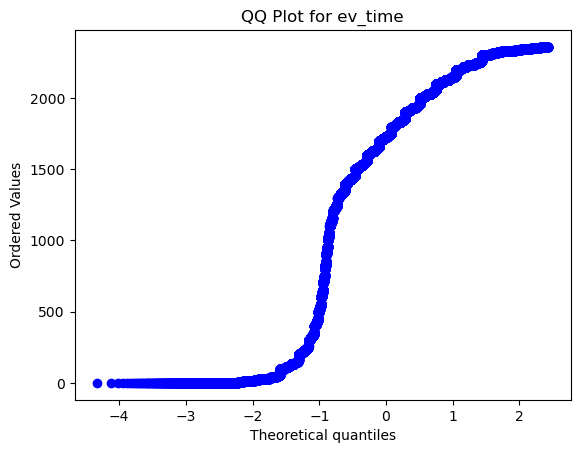

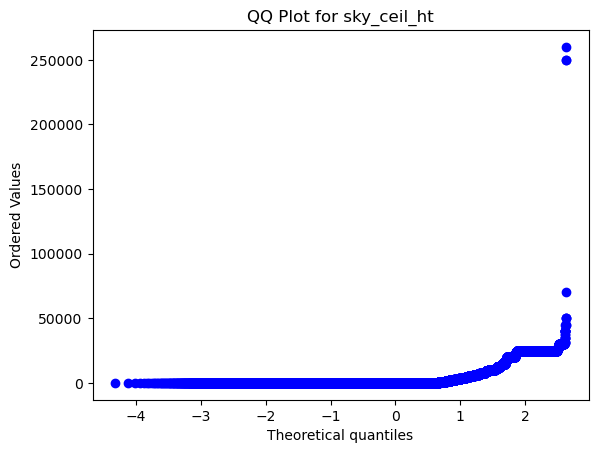

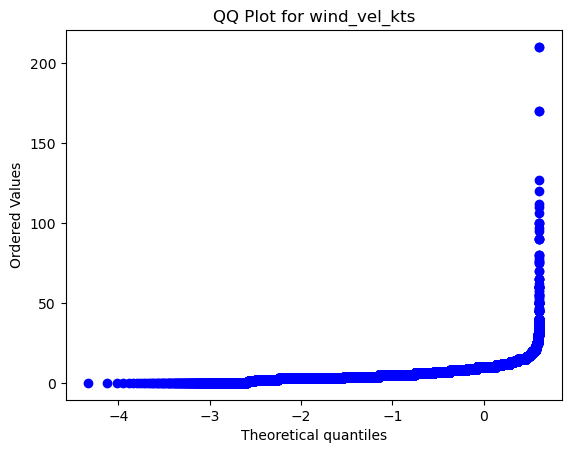

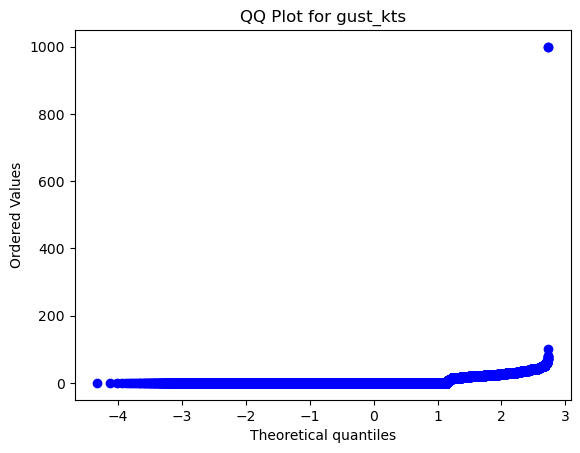

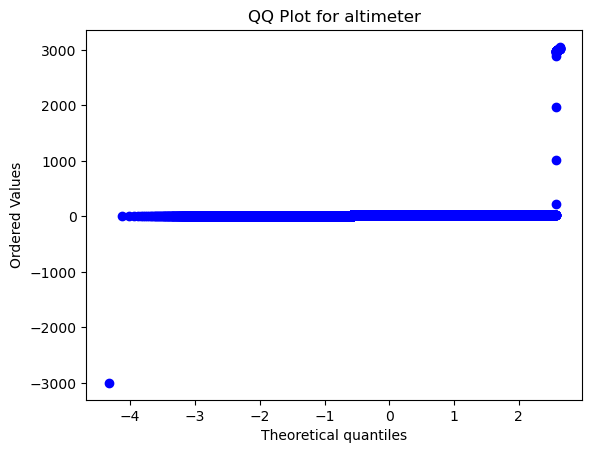

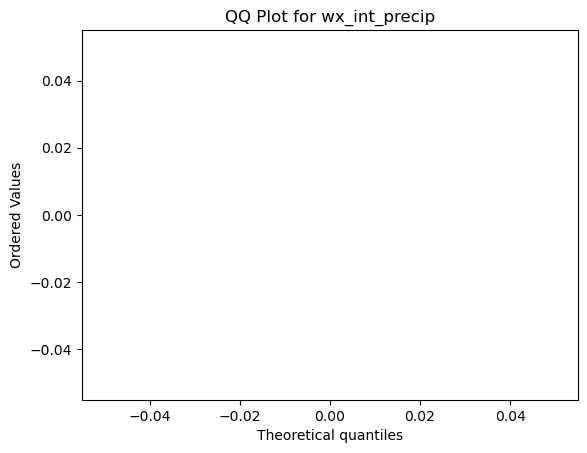

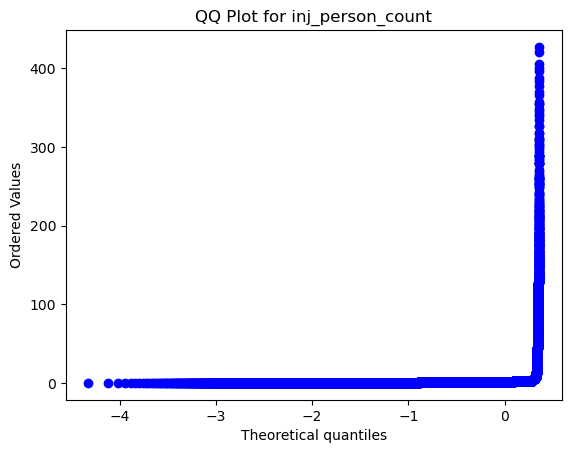

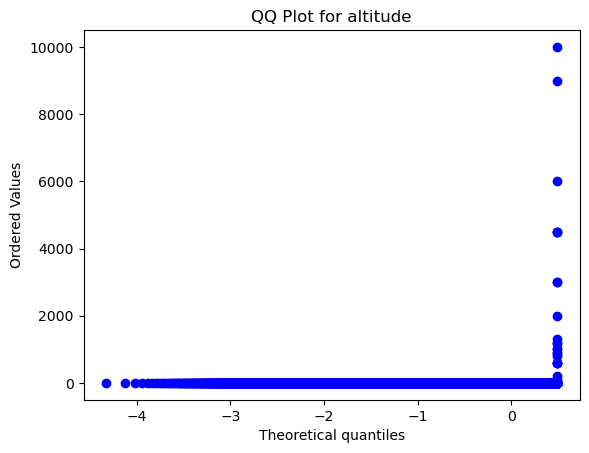

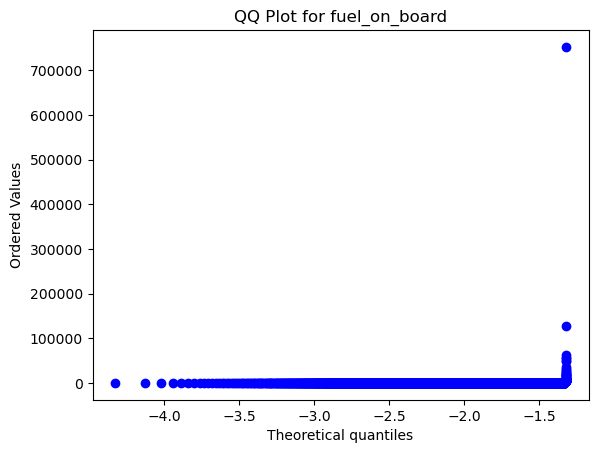

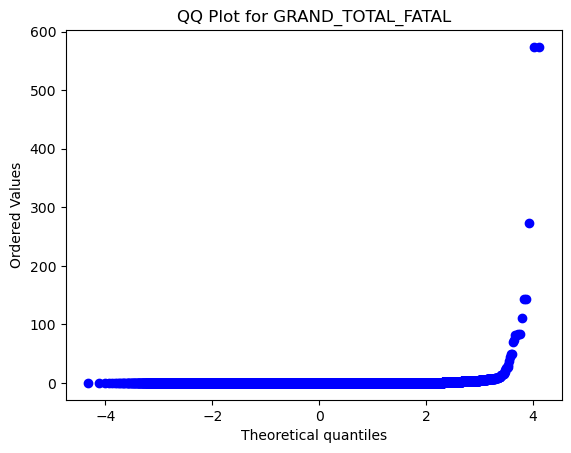

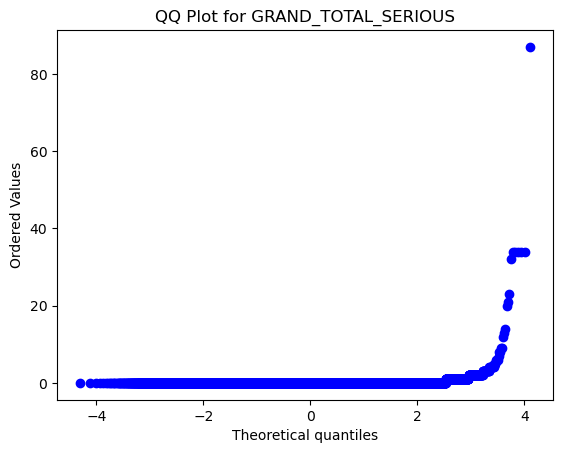

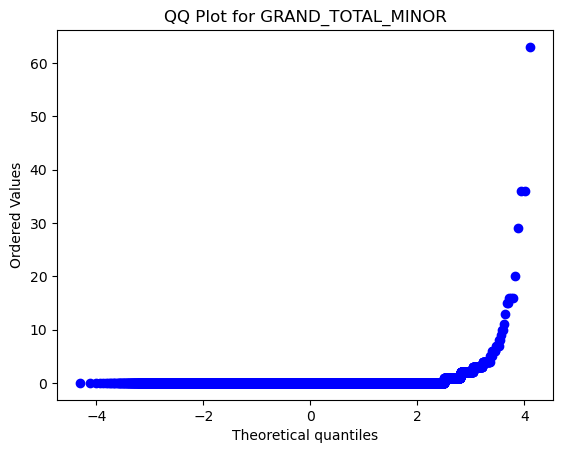

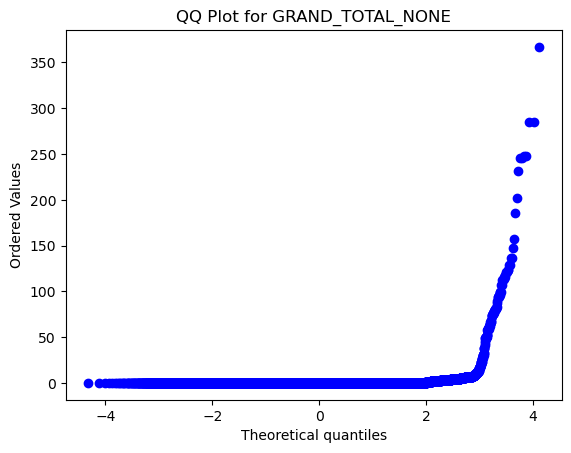

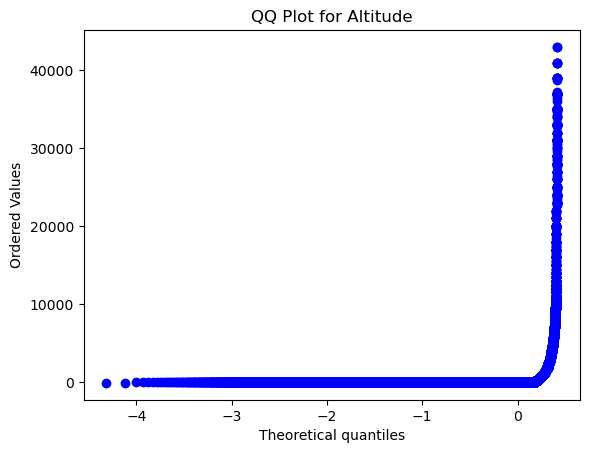

In [27]:
# QQ plot for normality check
def qq_plot(data, column):
    stats.probplot(data[column], dist="norm", plot=plt)
    plt.title(f"QQ Plot for {column}")
    plt.show()

# For data_start_1982_clean
for col in data_start_numerical_columns:
    qq_plot(data_start_1982_clean, col)

# For data_before_1982_clean
for col in data_before_numerical_columns:
    qq_plot(data_before_1982_clean, col)

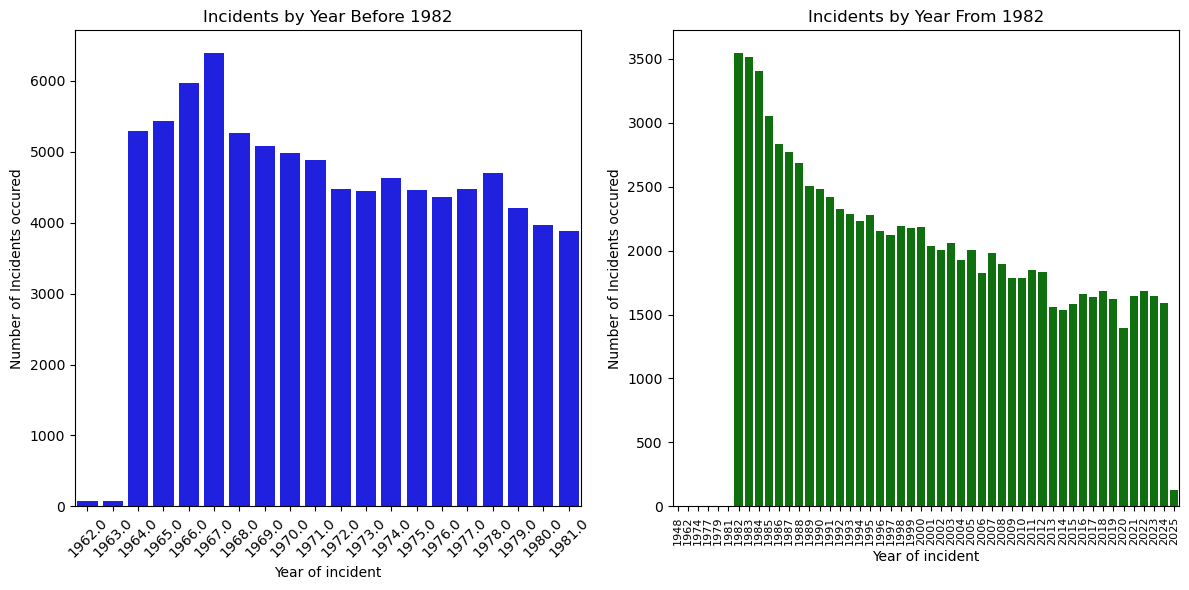

In [30]:
# Exploration of data further
data_before_1982_clean = data_before_1982.copy()
data_start_1982_clean = data_start_1982.copy()

# Converting the 'ev_date' and 'DATE_OCCURRENCE' to datetime format
data_before_1982_clean['DATE_OCCURRENCE'] = pd.to_datetime(data_before_1982_clean['DATE_OCCURRENCE'], errors='coerce')
data_start_1982_clean['ev_date'] = pd.to_datetime(data_start_1982_clean['ev_date'], errors='coerce')

# Extracting the year and month from 'ev_date' and 'DATE_OCCURRENCE'
data_before_1982_clean.loc[:, 'year'] = data_before_1982_clean['DATE_OCCURRENCE'].dt.year
data_before_1982_clean.loc[:, 'month'] = data_before_1982_clean['DATE_OCCURRENCE'].dt.month

data_start_1982_clean.loc[:, 'year'] = data_start_1982_clean['ev_date'].dt.year
data_start_1982_clean.loc[:, 'month'] = data_start_1982_clean['ev_date'].dt.month

# Counting the incidents by year for both datasets
incidents_by_year_before_1982 = data_before_1982_clean.groupby('year').size()
incidents_by_year_start_1982 = data_start_1982_clean.groupby('year').size()

# Plotting the incidents by year for both datasets
plt.figure(figsize=(12, 6))

# Plot for data before 1982
plt.subplot(1, 2, 1)
sns.barplot(x=incidents_by_year_before_1982.index, y=incidents_by_year_before_1982.values, color='blue')
plt.title('Incidents by Year Before 1982')
plt.xlabel('Year of incident')
plt.ylabel('Number of Incidents occured')
plt.xticks(rotation=45)

# Plot for data starting from 1982
plt.subplot(1, 2, 2)
sns.barplot(x=incidents_by_year_start_1982.index, y=incidents_by_year_start_1982.values, color='green')
plt.title('Incidents by Year From 1982')
plt.xlabel('Year of incident')
plt.ylabel('Number of Incidents occured')
plt.xticks(rotation=90, fontsize=8)

plt.tight_layout()
plt.show()


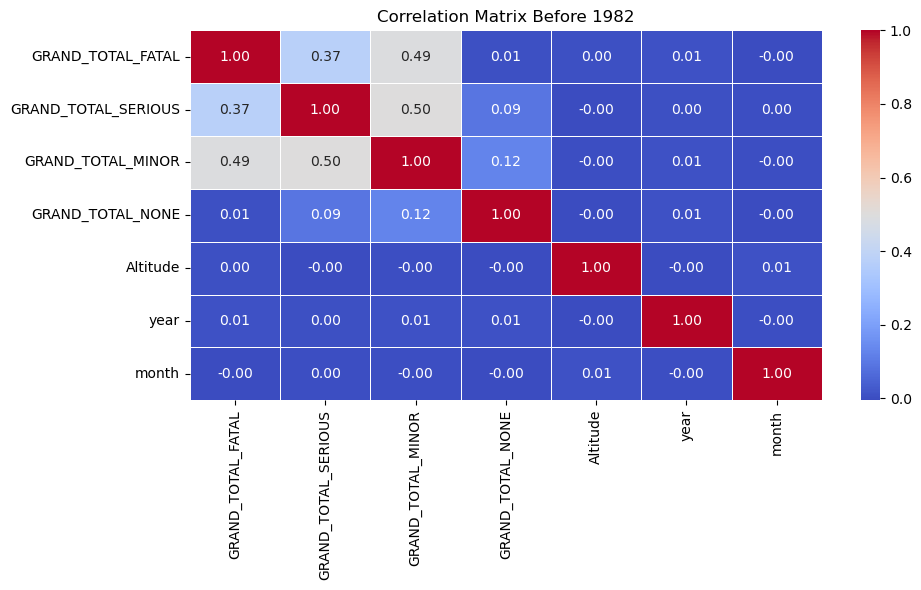

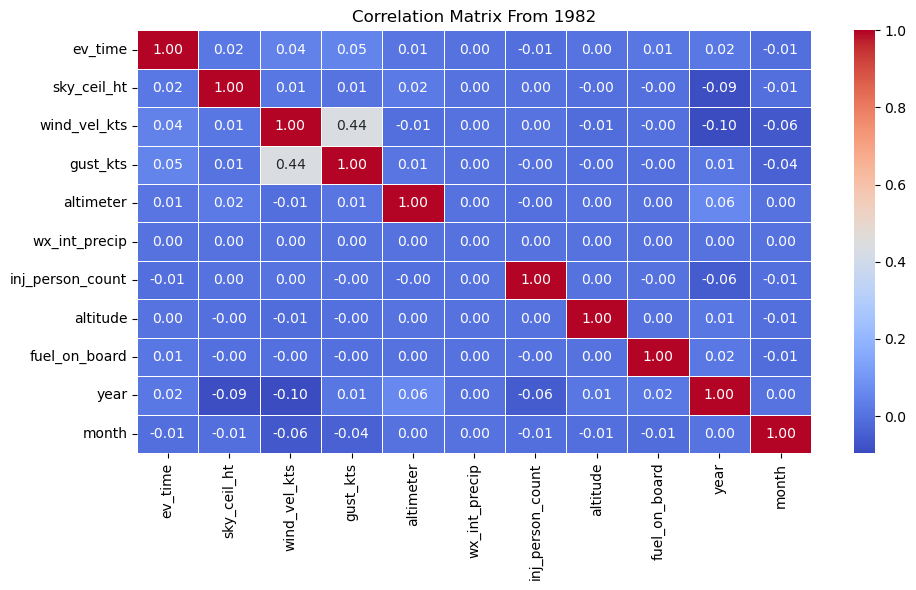

In [32]:
# selecting the numeric data for correlation plot
data_before_1982_clean_numeric = data_before_1982_clean.select_dtypes(include=['number'])
data_start_1982_clean_numeric = data_start_1982_clean.select_dtypes(include=['number'])

# calculating the correlations on the numeric data
corr_before_1982 = data_before_1982_clean_numeric.corr()
corr_after_1982 = data_start_1982_clean_numeric.corr()


# Heatmap for correlations before 1982
plt.figure(figsize=(10, 6))
sns.heatmap(corr_before_1982, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix Before 1982')
plt.tight_layout()
plt.show()


# Heatmap for correlations 1982 onwards
corr_after_1982 = corr_after_1982.fillna(0)
plt.figure(figsize=(10, 6))
sns.heatmap(corr_after_1982, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix From 1982')
plt.tight_layout()
plt.show()


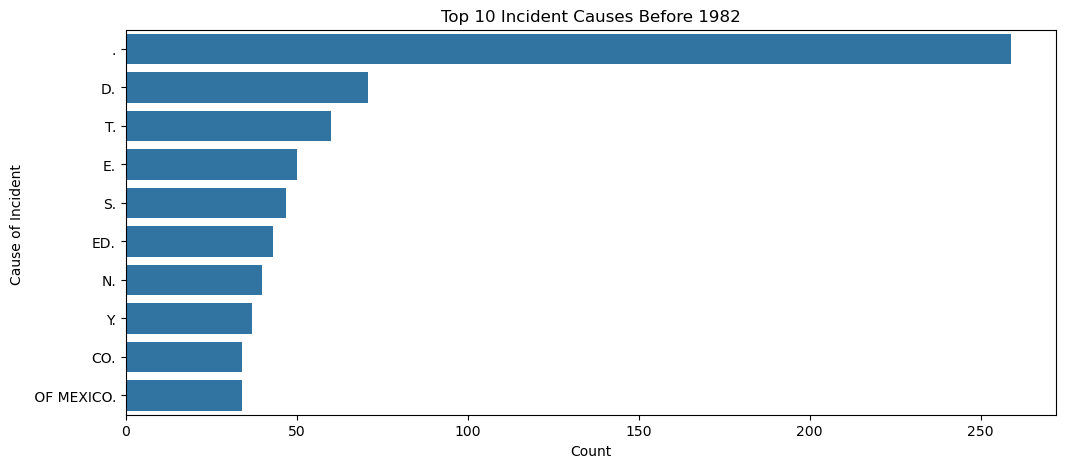

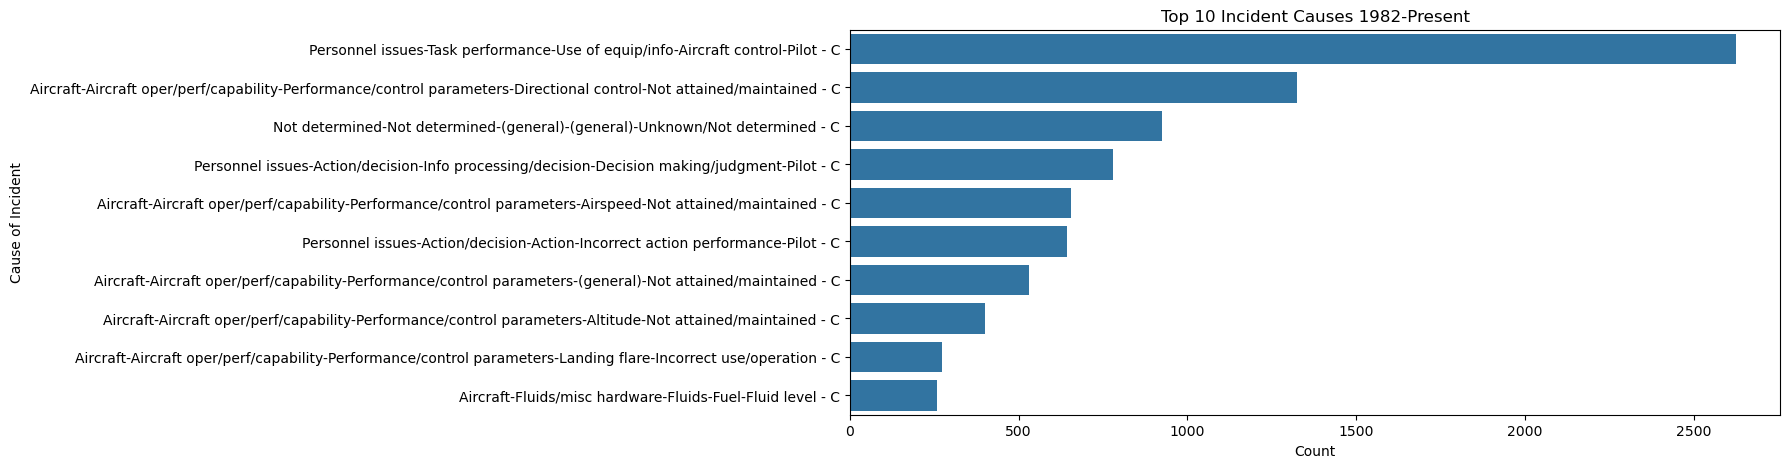

In [48]:
# Distribution of Cause Of Incident
# plotting the distribution of incidents before 1982
plt.figure(figsize=(12, 5))
top_causes = data_before_1982_clean["CAUSE"].value_counts().nlargest(10).index
sns.countplot(y=data_before_1982_clean[data_before_1982_clean["CAUSE"].isin(top_causes)]["CAUSE"], 
              order=top_causes)
plt.title("Top 10 Incident Causes Before 1982")
plt.xlabel("Count")
plt.ylabel("Cause of Incident ")
plt.show()


# Distribution of Cause of Incident
plt.figure(figsize=(12, 5))
top_causes = data_start_1982_clean["finding_description"].value_counts().nlargest(10).index
sns.countplot(y=data_start_1982_clean[data_start_1982_clean["finding_description"].isin(top_causes)]["finding_description"], 
              order=top_causes)
plt.title("Top 10 Incident Causes 1982-Present")
plt.xlabel("Count")
plt.ylabel("Cause of Incident")
plt.show()


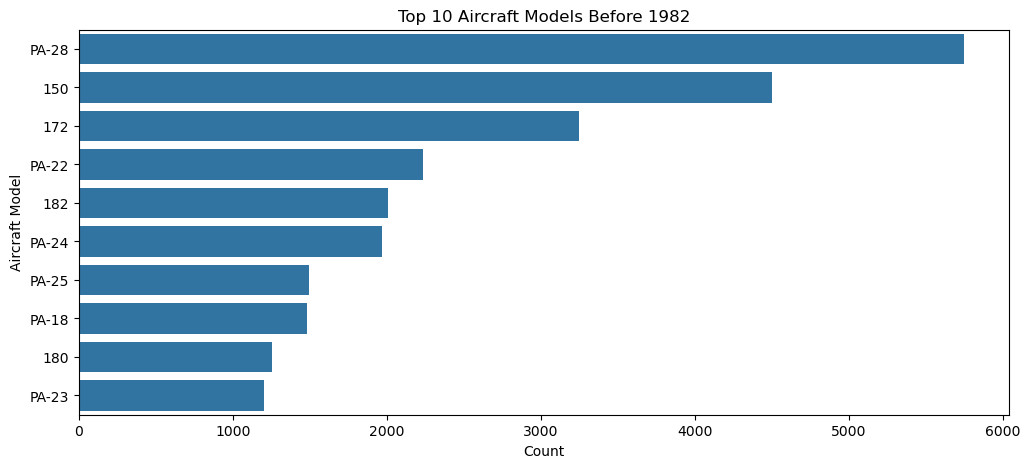

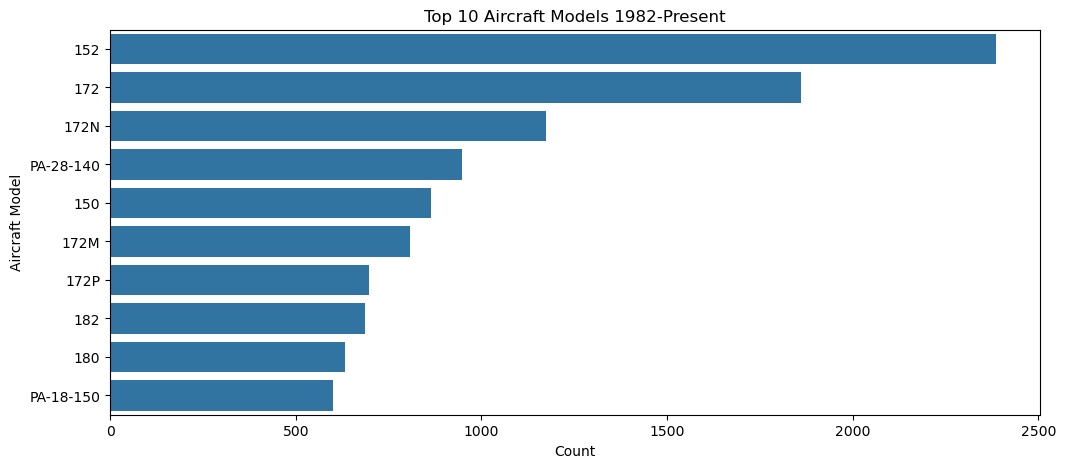

In [36]:
# Aircraft Model Analysis involved in an incident before 1982
plt.figure(figsize=(12, 5))
# Getting the top 10 aircraft models involved in an incident before 1982
top_models = data_before_1982_clean["ACFT_MODEL"].value_counts().nlargest(10).index

# Plot for aircraft models involved in an incident
sns.countplot(y="ACFT_MODEL", data=data_before_1982_clean, order=top_models)
plt.title("Top 10 Aircraft Models Before 1982")
plt.xlabel("Count")
plt.ylabel("Aircraft Model")
plt.show()


# Aircraft Model Analysis involved in an incident from 1982
data_start_1982_clean["acft_model"] = data_start_1982_clean["acft_model"].str.strip()
plt.figure(figsize=(12, 5))
# Getting the top 10 aircraft models involved in an incident from 1982
top_models = data_start_1982_clean["acft_model"].value_counts().nlargest(10).index
# Plot for aircraft models involved in an incident
sns.countplot(y="acft_model", data=data_start_1982_clean, order=top_models)
plt.title("Top 10 Aircraft Models 1982-Present")
plt.xlabel("Count")
plt.ylabel("Aircraft Model")
plt.show()


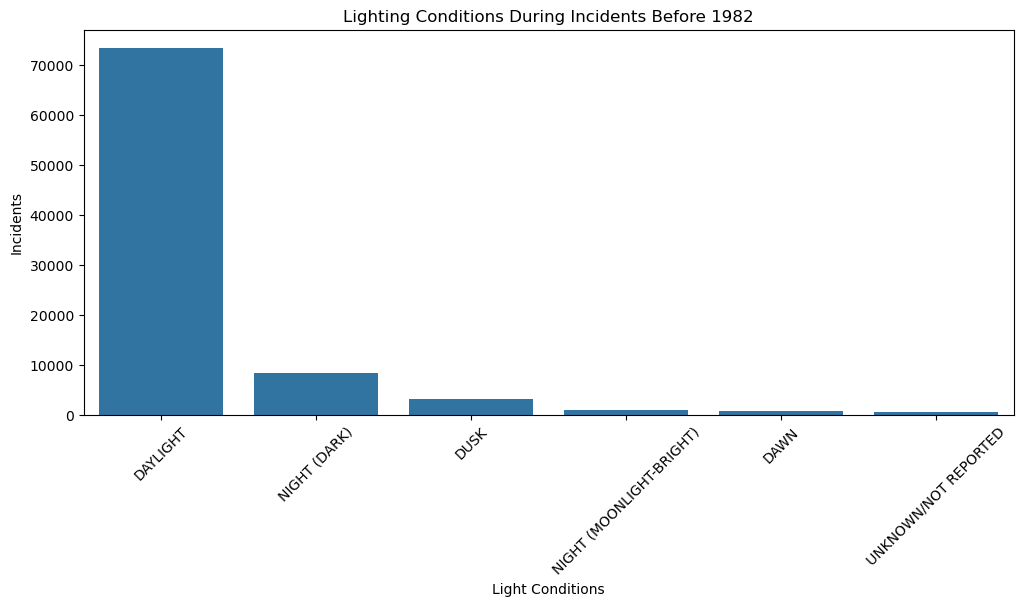

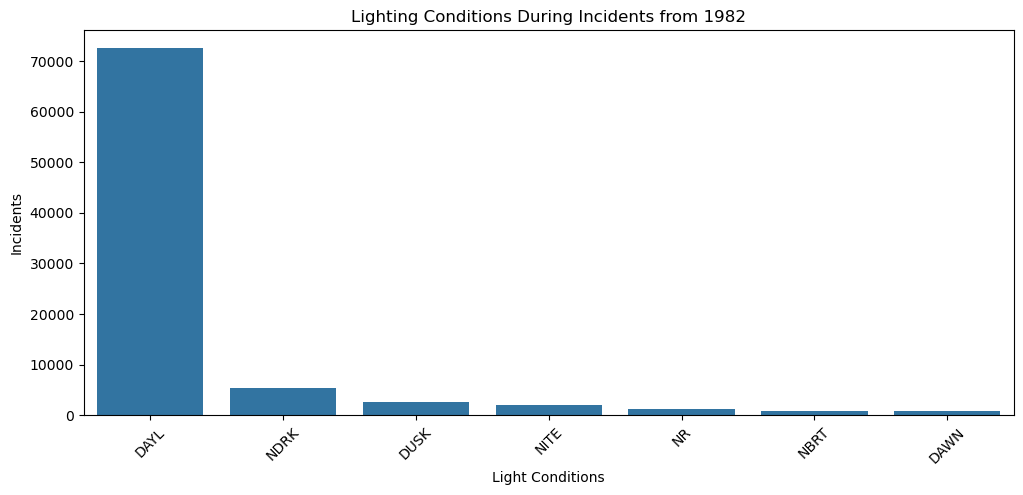

In [63]:
# Lightining conditions during the incident

# Dictionary mapping codes to full descriptions
light_cond_map = {
    'A': 'DAWN',
    'B': 'DAYLIGHT',
    'C': 'DUSK',
    'D': 'NIGHT (DARK)',
    'E': 'NIGHT (MOONLIGHT-BRIGHT)',
    'Z': 'UNKNOWN/NOT REPORTED'
}
# Replacing codes with full descriptions
data_before_1982_clean["LIGHT_COND_FULL"] = data_before_1982_clean["LIGHT_COND"].map(light_cond_map)

# Plot for Lightining conditions during the incident before 1982
plt.figure(figsize=(12, 5))
sns.countplot(x=data_before_1982_clean["LIGHT_COND_FULL"].dropna(), order=data_before_1982_clean["LIGHT_COND_FULL"].value_counts().index)
plt.title("Lighting Conditions During Incidents Before 1982")
plt.xlabel("Light Conditions")
plt.ylabel("Incidents")
plt.xticks(rotation=45)
plt.show()

# Plot for Lightining conditions during the incident from 1982
plt.figure(figsize=(12, 5))
sns.countplot(x=data_start_1982_clean["light_cond"].dropna(), order=data_start_1982_clean["light_cond"].value_counts().index)
plt.title("Lighting Conditions During Incidents from 1982")
plt.xlabel("Light Conditions")
plt.ylabel("Incidents")
plt.xticks(rotation=45)
plt.show()




# Completed Milestones
Elaborated data description, acquisition, cleaning, and exploratory analysis were done as part of the first milestone.

# Methods Milestones
Descriptive Statistics were done as part of the first milestone.

# Schedule
April 1, 2025 | Model development and hypothesis testing
April 8, 2025 | Refinement and documentation
April 15, 2025 | Final submission and presentation preparation